<a href="https://colab.research.google.com/github/rzunick/MNA-Navegacion-Autonoma-Equipo-14/blob/main/Proyecto_Final_Equipo_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

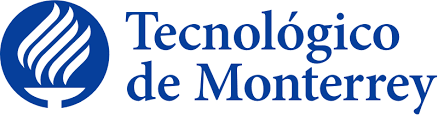

# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Navegación autónoma**
## Profesor: David Antonio Torres
## Proyecto Final - Behavioral Cloning
## **Equipo 14**:
### - *Alejandro Juárez Corona-A01168444*
### - *Juan Carlos Lopez Cruz- A01793052*
### - *Ronald David Zúniga Sánchez-A01686240*
### - *Rodrigo López Aguilera-A01793071*

### **Importar Librerías**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

import cv2
import pandas as pd
import random
import os
import ntpath

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.image as mpimg
from imgaug import augmenters as iaa

In [2]:
if tf.test.gpu_device_name():
    print('GPU device found:', tf.test.gpu_device_name())
else:
    print("No GPU found. Please check the runtime configuration.")

GPU device found: /device:GPU:0


In [3]:
# Specify the GPU device to use (if multiple GPUs are available)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Verify TensorFlow is using GPU
print('TensorFlow is using GPU:', tf.test.is_built_with_cuda())

TensorFlow is using GPU: True


### Conexión con Github.

In [4]:
!git clone https://github.com/rzunick/MNA-Navegacion-Autonoma-Equipo-14.git

Cloning into 'MNA-Navegacion-Autonoma-Equipo-14'...
remote: Enumerating objects: 34905, done.
remote: Counting objects: 100% (1092/1092), done.
remote: Compressing objects: 100% (1047/1047), done.
remote: Total 34905 (delta 53), reused 1069 (delta 44), pack-reused 33813
Receiving objects: 100% (34905/34905), 547.01 MiB | 29.60 MiB/s, done.
Resolving deltas: 100% (55/55), done.
Updating files: 100% (34798/34798), done.


### Preparación de Base de Datos

In [38]:
#Inicializamos carpeta de trabajo e importamos archivo csv

datadir = "/content/MNA-Navegacion-Autonoma-Equipo-14/data/udacity_sim/track_1"

columns = ['center', 'left', 'right', 'steering', 'throttle',
'reverse', 'speed']

data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)

pd.set_option('display.max_colwidth', -1)

data.head()

<ipython-input-38-6e329d289c24>:10: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


center  \
0  C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\center_2023_06_19_22_04_58_723.jpg   
1  C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\center_2023_06_19_22_04_58_792.jpg   
2  C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\center_2023_06_19_22_04_58_864.jpg   
3  C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\center_2023_06_19_22_04_58_937.jpg   
4  C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\center_2023_06_19_22_04_59_008.jpg   

                                                                                   left  \
0  C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\left_2023_06_19_22_04_58_723.jpg   
1  C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\left_2023_06_19_22_04_58_792.jpg   
2  C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\left_2023_06_19_22_04_58_864.jpg   
3  C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\left_2023_06_19_22_04_58_937.jpg   
4  C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\left_2023_06_19_22_04_59_008.jpg   

                                                                                   right  \
0  C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\right_2023_06_19_22_04_58_723.jpg   
1  C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\right_2023_06_19_22_04_58_792.jpg   
2  C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\right_2023_06_19_22_04_58_864.jpg   
3  C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\right_2023_06_19_22_04_58_937.jpg   
4  C:\Users\rzuniga\Documents\udacity_data\track_1\IMG\right_2023_06_19_22_04_59_008.jpg   

   steering  throttle  reverse      speed  
0  0.0       1.0       0        6.762121   
1  0.0       1.0       0        7.674099   
2  0.0       1.0       0        8.353499   
3 -0.1       1.0       0        9.251003   
4 -0.3       1.0       0        10.119220

In [39]:
# Depuración de datos para dejar solo el nombre del archivo unicamente

def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center                              left  \
0  center_2023_06_19_22_04_58_723.jpg  left_2023_06_19_22_04_58_723.jpg   
1  center_2023_06_19_22_04_58_792.jpg  left_2023_06_19_22_04_58_792.jpg   
2  center_2023_06_19_22_04_58_864.jpg  left_2023_06_19_22_04_58_864.jpg   
3  center_2023_06_19_22_04_58_937.jpg  left_2023_06_19_22_04_58_937.jpg   
4  center_2023_06_19_22_04_59_008.jpg  left_2023_06_19_22_04_59_008.jpg   

                               right  steering  throttle  reverse      speed  
0  right_2023_06_19_22_04_58_723.jpg  0.0       1.0       0        6.762121   
1  right_2023_06_19_22_04_58_792.jpg  0.0       1.0       0        7.674099   
2  right_2023_06_19_22_04_58_864.jpg  0.0       1.0       0        8.353499   
3  right_2023_06_19_22_04_58_937.jpg -0.1       1.0       0        9.251003   
4  right_2023_06_19_22_04_59_008.jpg -0.3       1.0       0        10.119220

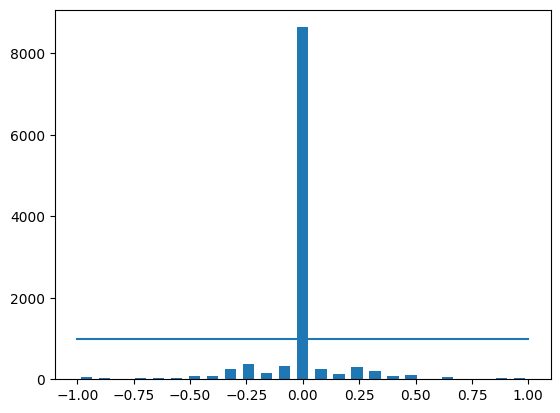

In [40]:
# Visualización de la base de datos para observar distribución

num_bins = 25
samples_per_bin = 1000

hist, bins = np.histogram(data['steering'], num_bins)

center = (bins[:-1]+ bins[1:]) * 0.5

plt.bar(center, hist, width=0.05)

plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))

Se observa que la base de datos tiene muchos más registros en "ángulo 0" los cuales corresponden a imágenes tomadas mientras el vehículo se trasladaba en línea recta.

Para obtener un dataset más equilibrado entre clases (ángulos para el manejo automático), es necesario truncar el número de datos máximo.

total data: 11269
removed: 7637
remaining: 3632


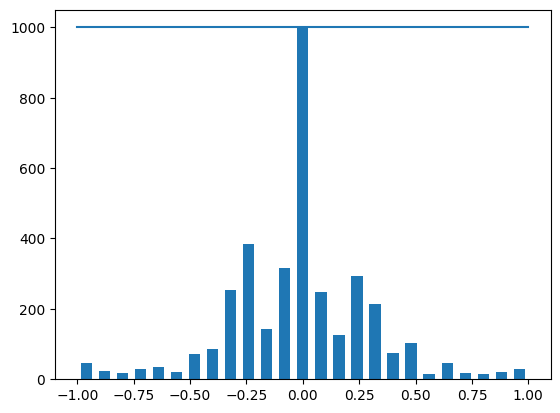

In [41]:
# Se depura el dataset utilizando el valor de la variable samples_per_bin para truncar el máximo de elementos por clase.

print('total data:', len(data))
remove_list = []

for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i]<= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))

plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))

In [42]:
# Se imprime los datos ejemplo de uno de los datapoints
print(data.iloc[1])

# Se define función para cargar las imágenes en formato de np array en variable image_paths y se carga variable dependiente "steering" en df steerings.
def load_img_steering(datadir, df):
  image_path = []
  steering = []

  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1],indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))

    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)

    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)

  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2023_06_19_22_04_58_864.jpg
left        left_2023_06_19_22_04_58_864.jpg  
right       right_2023_06_19_22_04_58_864.jpg 
steering    0.0                               
throttle    1.0                               
reverse     0                                 
speed       8.353499                          
Name: 2, dtype: object


In [43]:
# Se preparan los sub-conjuntos de entrenamiento y validación.
X_train, X_valid, y_train, y_valid = train_test_split(image_paths,steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples:{}'.format(len(X_train), len(X_valid)))

Training Samples: 8716
Valid Samples:2180


Text(0.5, 1.0, 'Validation set')

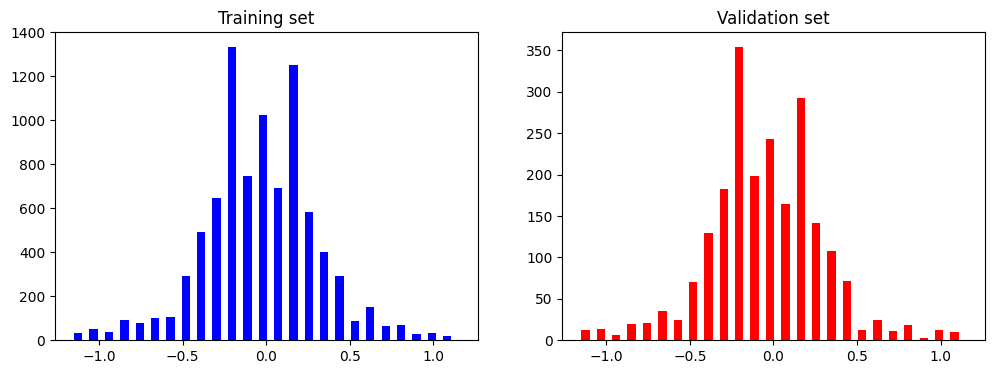

In [44]:
# Se visualizan las distribuciones de los sub-conjuntos de entrenamiento y validación.
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

Se observa que se obtienen dos sub-conjuntos con clases balanceadas.

Se procede a revisar las imágenes importadas y realizar procesos de augmentación en caso de requerirse.

**Image Aumentation 1 - Zoom**

Text(0.5, 1.0, 'Zoomed Image')

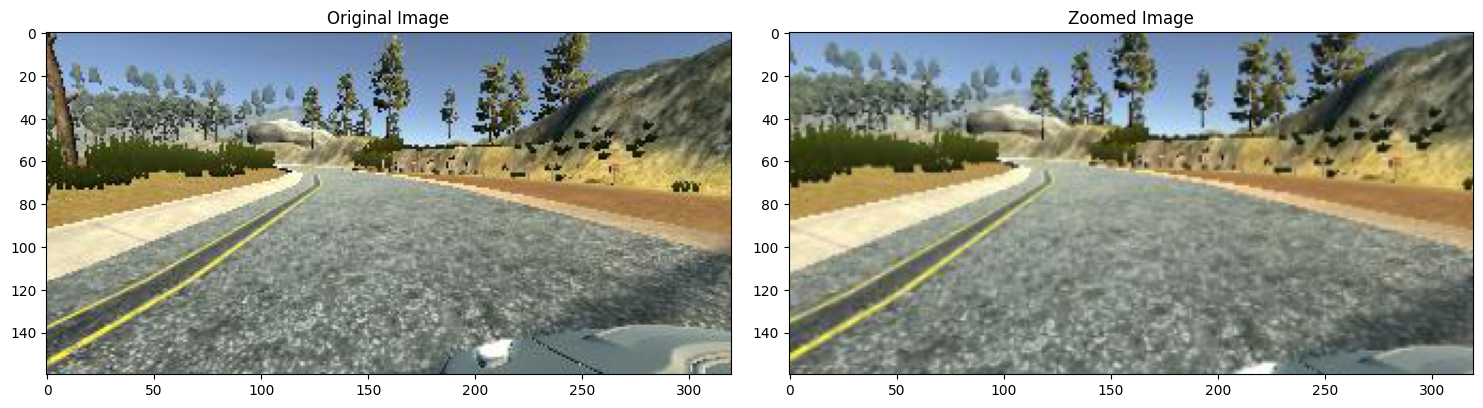

In [45]:
# Se realiza procesamiento de zoom para enfocar región de interés

# Se define función para aplicar zoom
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

# Ejemplo de aplicación de función en una imagen aleatoria
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

# Visualización de imágen original vs imagen modificada
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

**Image Aumentation 2 - Panning**

Text(0.5, 1.0, 'Panned Image')

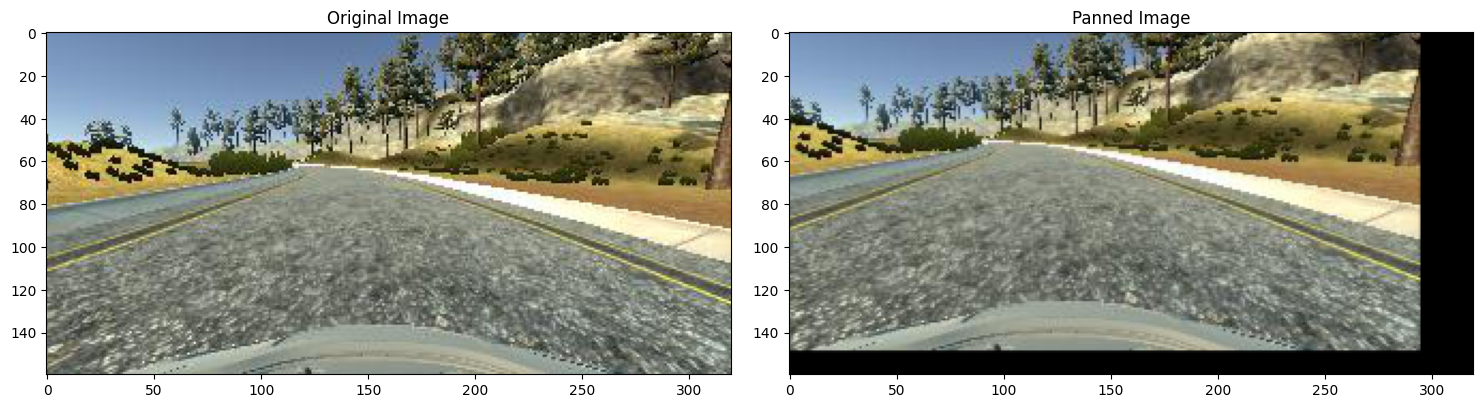

In [46]:
# Se define función para aplicar paneo aleatorio
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y":(-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

# Ejemplo de aplicación de función en una imagen aleatoria
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

# Visualización de imágen original vs imagen modificada
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

**Image Aumentation 3 - Brightness**

Text(0.5, 1.0, 'Brightness altered image ')

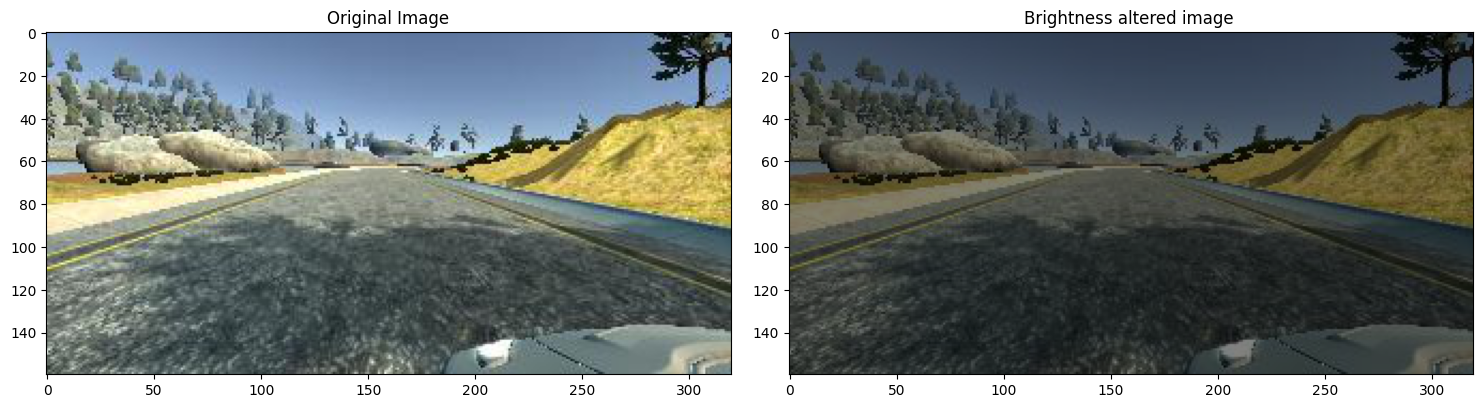

In [47]:
# Se define función para aplicar modificación de brillo aleatorio
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

# Ejemplo de aplicación de función en una imagen aleatoria
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

# Visualización de imágen original vs imagen modificada
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

**Image Aumentation 4 - Horizontal and Vertical Flip**

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.35')

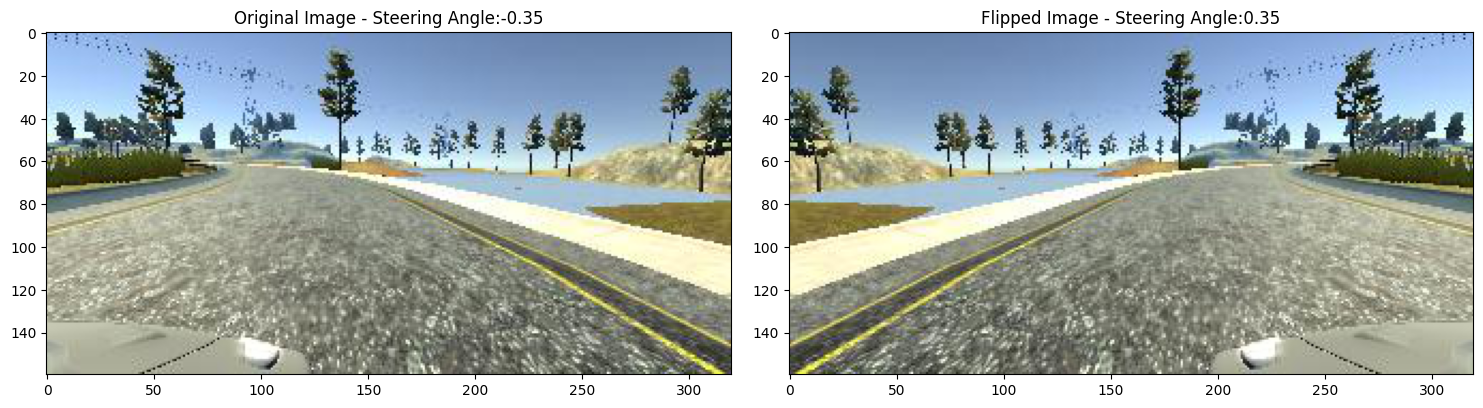

In [48]:
# Se define función para aplicar modificación de orientación vertical y horizontal aleatorio
def img_random_flip(image, steering_angle):
  image = cv2.flip(image,1)
  steering_angle = -steering_angle
  return image, steering_angle

# Ejemplo de aplicación de función en una imagen aleatoria
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

# Visualización de imágen original vs imagen modificada
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

**Image Aumentation 5 - Steering Angle Based Flip**

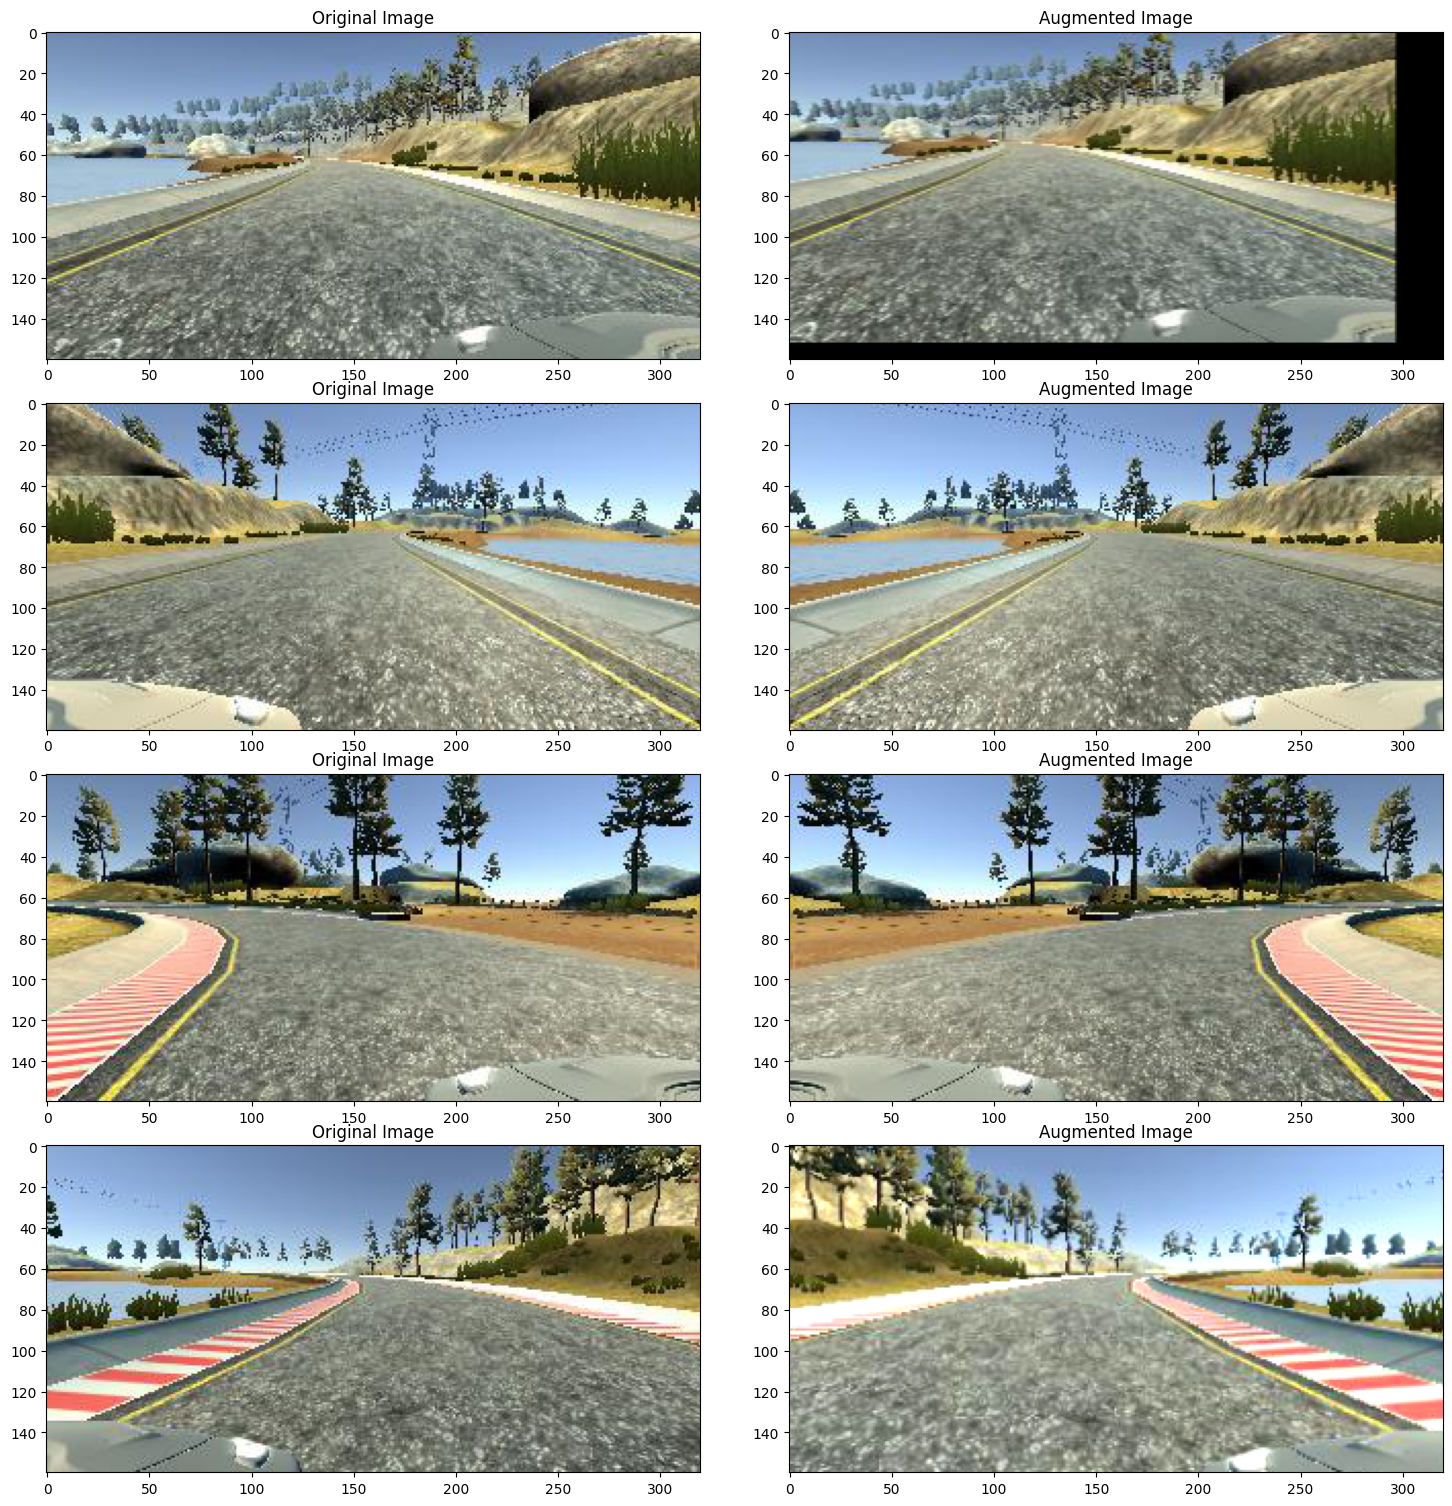

In [49]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image,steering_angle)
  return image, steering_angle

ncol = 2
nrow = 4

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 15))
fig.tight_layout()

for i in range(4):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image,random_steering)
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

**Image Aumentation 6 - Image Crop + Gaussian Blur**

Text(0.5, 1.0, 'Preprocessed Image')

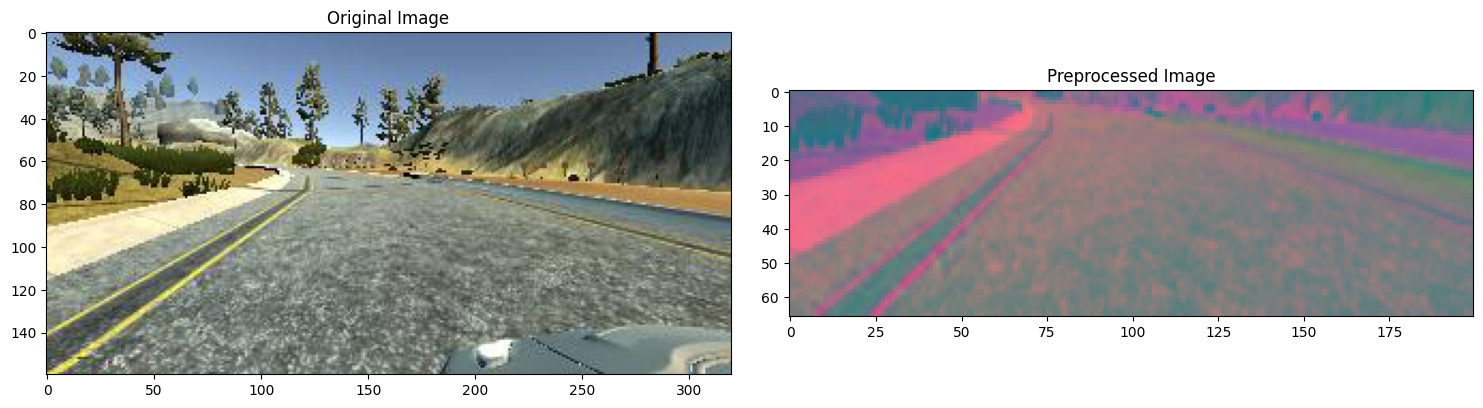

In [50]:
def img_preprocess(img):
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

Una vez listos las funciones para la augmentación de las imágenes, se procede a realizar la carga del dataset final para entrenamiento y validación aplicando las augmentaciones.

Se define un método llamado "batch_generator" que utiliza una instancia del objeto "dataset" de la clase Sequence (keras.utils.Sequence) para evitar datos duplicados cuando utilizamos multiprocesamiento. Proporciona objetos de tipo tuple; ya sea (input, target) o (input, target, sample_weight).

Text(0.5, 1.0, 'Validation Image')

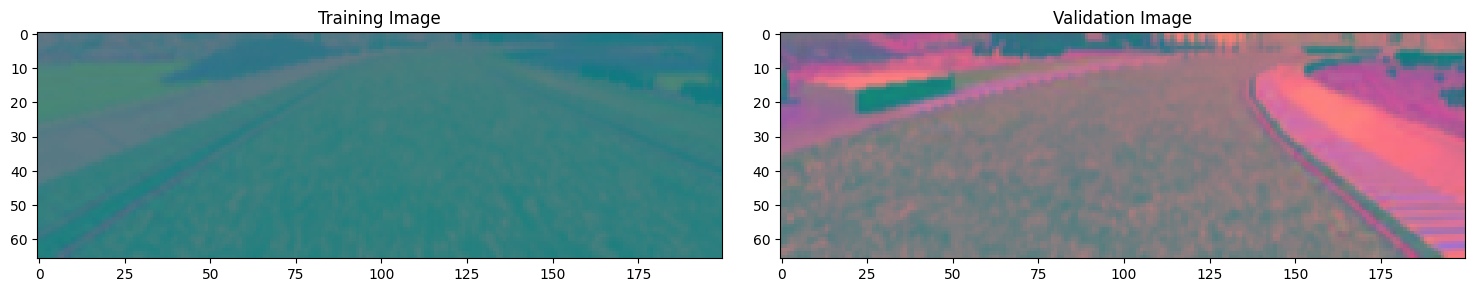

In [51]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      if istraining:
        im, steering = random_augment(image_paths[random_index],steering_ang[random_index])

      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)

    yield (np.asarray(batch_img), np.asarray(batch_steering))

x_train_gen, y_train_gen = next(batch_generator(X_train, y_train,1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid,1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

### Preparación de Red Neuronal

In [52]:
from keras.callbacks import ReduceLROnPlateau

def nvidia_model():
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv2D(24,kernel_size=(5,5),strides=(2,2),input_shape=(66,200,3),activation="elu"))
  model.add(tf.keras.layers.Conv2D(36,kernel_size=(5,5),strides=(2,2),activation="elu"))
  model.add(tf.keras.layers.Conv2D(48,kernel_size=(5,5),strides=(2,2),activation="elu"))
  model.add(tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation="elu"))

  model.add(tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation="elu"))

  model.add(Dropout(0.2))

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(100,activation="elu"))
  #model.add(Dropout(0.2))
  model.add(tf.keras.layers.Dense(50,activation="elu"))
  #model.add(Dropout(0.2))
  model.add(tf.keras.layers.Dense(10,activation="elu"))
  #model.add(Dropout(0.2))
  model.add(tf.keras.layers.Dense(1))

  optimizer = Adam(lr=1e-3)
  model.compile(loss="mse",optimizer=optimizer)

  # Learning rate schedule
  lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, verbose=1)

  return model, lr_scheduler

model, lr_scheduler = nvidia_model()
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_36 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_37 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_38 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_39 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 dropout_24 (Dropout)        (None, 1, 18, 64)         0         
                                                                 
 flatten_7 (Flatten)         (None, 1152)             

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [53]:
history = model.fit_generator(
    batch_generator(X_train, y_train, 100, 1),
    steps_per_epoch=300,
    epochs=30,
    validation_data=batch_generator(X_valid, y_valid, 100, 0),
    validation_steps=200,
    verbose=1,
    shuffle = 1,
    callbacks=[lr_scheduler]
    )

<ipython-input-53-3b579ed9e051>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
300/300 [==============================] - 163s 541ms/step - loss: 0.1181 - val_loss: 0.0810 - lr: 0.0010
Epoch 2/30
300/300 [==============================] - 153s 511ms/step - loss: 0.0873 - val_loss: 0.0671 - lr: 0.0010
Epoch 3/30
300/300 [==============================] - 155s 518ms/step - loss: 0.0765 - val_loss: 0.0594 - lr: 0.0010
Epoch 4/30
300/300 [==============================] - 149s 500ms/step - loss: 0.0689 - val_loss: 0.0557 - lr: 0.0010
Epoch 5/30
300/300 [==============================] - 150s 501ms/step - loss: 0.0657 - val_loss: 0.0552 - lr: 0.0010
Epoch 6/30
300/300 [==============================] - 148s 494ms/step - loss: 0.0650 - val_loss: 0.0531 - lr: 0.0010
Epoch 7/30
300/300 [==============================] - 148s 496ms/step - loss: 0.0617 - val_loss: 0.0533 - lr: 0.0010
Epoch 8/30
300/300 [==============================] - 149s 498ms/step - loss: 0.0614 - val_loss: 0.0570 - lr: 0.0010
Epoch 9/30
300/300 [==============================] - ETA: 0s - 

Text(0.5, 0, 'Epoch')

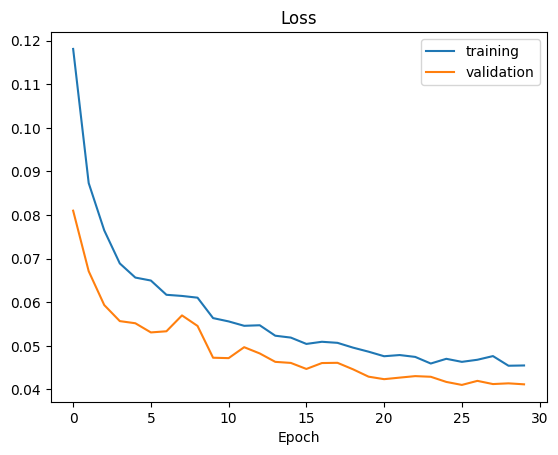

In [54]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["training","validation"])
plt.title("Loss")
plt.xlabel("Epoch")

In [55]:
model.save("model_E.h5")

**Notas de modelos:**

1.   Modelo A: se entrena con parámetros originales de red neuronal nvidia_model.

     Resultados:
*   loss = 0.0658
*   val_loss = 0.0522



2.   Modelo B: se entrena incluyendo una capa adicional de Dropout con valor de 0.5 previo a las capas Dense.

     Resultados:
*   loss = 0.0703
*   val_loss = 0.0591



3.   Modelo C: se entrena aumentando epochs a 30 para explorar si el modelo con los parámetros existentes tiene espacio de mejora si se le permite más recurrencias.

     Resultados:
*   loss = 0.0484
*   val_loss = 0.0490



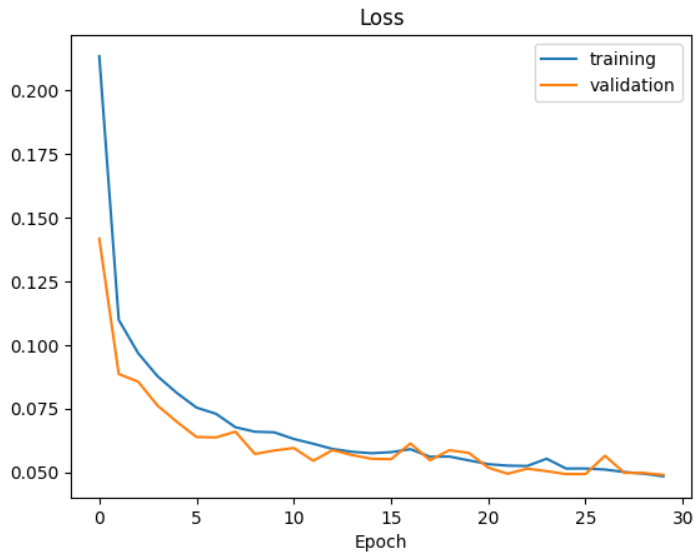

4. Modelo D: se entrena agregando capas de dropout con valor de 0.2 previo e intermedio de las capas Dense como técnica de regularización para prevenir overfitting. Adicionalmente se agrega la técnica de Learning Rate scheduling para usar un learning rate dinámico en lugar de estático durante el entrenamiento para ayudar al modelo a converger más rápido y llegar a un mejor mínimo utilizando "ReduceLROnPlateau" callback.

     Resultados:
*   loss = 0.0681
*   val_loss = 0.0615

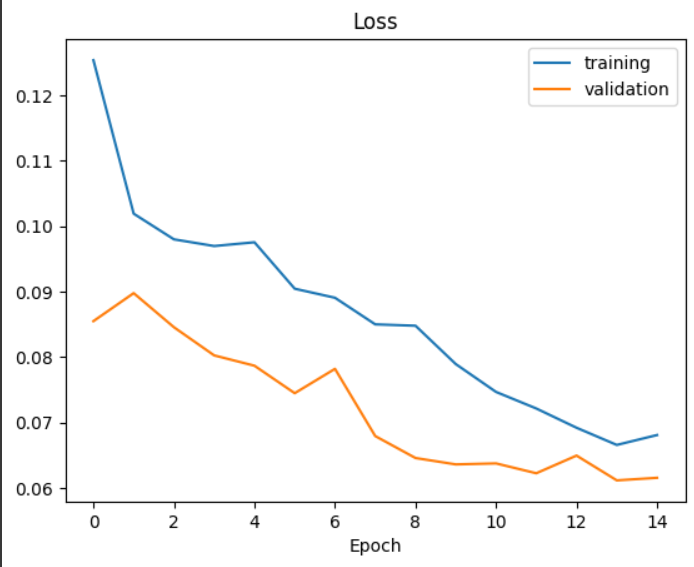

5. Modelo E: se entrena aumentando el tamaño del dataset modificando el truncamiento de imágenes para balanceo de clases de 400 a 1000 samples. Por ende aumentando el tamaño del dataset en alrededor de 1000 imágenes. Adicionalmente se configura de nuevo con 30 epocas y learning rate variable para apoyar con la convergencia.

     Resultados:
*   loss = 0.0455
*   val_loss = 0.0412

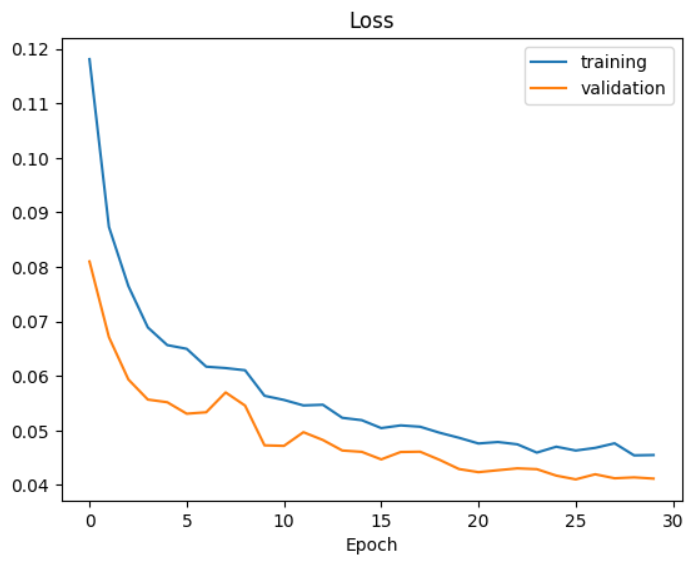

### **Conclusiones**

### Video Resumen

### **Referencias**